In [1]:
# Imports
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.linalg import inv, det
from sklearn.preprocessing import MinMaxScaler as Scaler
sns.set()

np.random.seed(7)

## Defs

In [2]:
def error_rate(y, y_pred):
    N = y.shape[0]
    return np.sum(y != y_pred) / N

def shuffle_index(N):
    shuffled_idx = np.random.permutation(N)
    return shuffled_idx

In [3]:
# knn clasiffier

def knn_predict(X_train, y_train, X_test, k):
    (N, d) = X_train.shape
    N_te = X_test.shape[0]
    
    y_pred = np.zeros(N_te)
    for i in range(N_te):
        A = X_train - X_test[i,:]
        
        # compute l_2 distances
        D = np.sqrt(np.sum(A**2, axis=1))
        
        # indices of k closest points, NOT sorted
        idx = np.argpartition(D, k)[:k]
        
        # labels vs times they appear out of k
        label, counts = np.unique(y_train[idx], return_counts=True)
        
        max_count = np.max(counts)
        labels = label[counts == max_count] 
        
        if (len(labels) == 1):
            y_pred[i] = labels[0]
        else:
            # break ties arbitrarily
            y_pred[i] = np.random.choice(labels, 1)[0]
            
    y_pred = y_pred.astype(int)
    return y_pred

In [4]:
# kfold cross validation for knn

def kfold_cv_knn(X, y, shuffled_idx, n_folds, k, scale_data):
    N = X.shape[0]
    C = N // n_folds
    errors = []
    for i in range(0, C*n_folds, C):
        
        # indices for test set
        idx_test = shuffled_idx[i: i+C]
        
        # indices for train set
        left = shuffled_idx[0:i]
        right = shuffled_idx[i+C: N]
        idx_train = np.concatenate((left,right))
        
        # Create training set and test set
        X_tr = X[idx_train, :]
        y_tr = y[idx_train]
        X_te = X[idx_test, :]
        y_te = y[idx_test]
        
        # Data should be scaled for kNN
        if scale_data == True:
            scaler = Scaler()
            scaler.fit(X_tr)
            X_tr_scaled = scaler.transform(X_tr)
            X_te_scaled = scaler.transform(X_te)
            y_pred = knn_predict(X_tr_scaled, y_tr, X_te_scaled, k)
        else:
            y_pred = knn_predict(X_tr, y_tr, X_te, k)
        
        error = error_rate(y_te, y_pred)
        errors.append(error)
    
    CV_error = np.sum(errors) / len(errors)
    return CV_error

In [5]:
# Bayes classifier

def bayes_train(X_data):
    N = X_data.shape[0]
    # sort data according to class
    sort = X_data[X_data[:,8].argsort()]
    
    counter_0 = int(N - np.sum(sort[:,8]))

    # Create two datasets, one for each class
    c_0 = sort[0:counter_0,:]
    c_1 = sort[counter_0:,:]
    
    # Compute prior probabilities
    p_0 = round(len(c_0)/len(sort), 3)
    p_1 = 1 - p_0
    
    # Compute the mean vector for each class
    m_0 = c_0[:,0:8].mean(0).reshape((8,1)).T
    m_1 = c_1[:,0:8].mean(0).reshape((8,1)).T
    
    # Compute the covariance matrix for each class
    S_0 = np.cov(c_0[:,0:8], rowvar = False)
    S_1 = np.cov(c_1[:,0:8], rowvar = False)
    
    return S_0, S_1, m_0, m_1, p_0, p_1


def bayes_predict(X_test, S_0, S_1, m_0, m_1, p_0, p_1):

    g_0 = - 0.5*( (X_test - m_0) @ inv(S_0) @ (X_test - m_0).T ) + np.log(p_0) - 0.5*np.log(det(S_0))
    g_1 = - 0.5*( (X_test - m_1) @ inv(S_1) @ (X_test - m_1).T ) + np.log(p_1) - 0.5*np.log(det(S_1))
    
    d_0 = np.diag(g_0)
    d_1 = np.diag(g_1)
    y = (d_1 > d_0)*1

    return y

In [6]:
def kfold_cv_bayes(X_data, shuffled_idx, n_folds):
    N = X_data.shape[0]
    C = N // n_folds
    errors = []
    for i in range(0, C*n_folds, C):
        
        # indices for test set
        idx_test = shuffled_idx[i: i+C]
        
        # indices for train set
        left = shuffled_idx[0:i]
        right = shuffled_idx[i+C: N]
        idx_train = np.concatenate((left,right))
        
        # Create training set and test set
        train_set = X_data[idx_train, :]
        test_set = X_data[idx_test, :]
        X_test = test_set[:,0:8]
        y_test = test_set[:,8]
        
        # cross-validation
        S_0, S_1, m_0, m_1, p_0, p_1 = bayes_train(train_set)
        y_pred = np.zeros(C)
        y_pred = bayes_predict(X_test, S_0, S_1, m_0, m_1, p_0, p_1)
                
        error = error_rate(y_test, y_pred)
        errors.append(error)
    
    CV_error = np.sum(errors) / len(errors)
    return CV_error, S_0.shape, m_0.shape, test_set[:,0:8].shape

In [7]:
# Naive Bayes Classifier

def naive_bayes_train(X_data):
    N = X_data.shape[0]
    # sort data according to class
    sort = X_data[X_data[:,8].argsort()]
    
    counter_0 = int(N - np.sum(sort[:,8]))

    # Create datasets for the two separate classes
    c_0 = sort[0:counter_0,:]
    c_1 = sort[counter_0:,:]
    
    # Compute prior probabilities
    p_0 = round(len(c_0)/len(sort), 3)
    p_1 = 1 - p_0
    
    # Compute the mean vector for each class
    m_0 = c_0[:,0:8].mean(0)
    m_1 = c_1[:,0:8].mean(0)
    
    # Compute the variance for each feature and for each class
    var_0 = c_0[:,0:8].var(0)
    var_1 = c_1[:,0:8].var(0)
    
    return var_0, var_1, m_0, m_1, p_0, p_1

def p_x_given_y(x, mean_y, var_y):
    prod = 1
    for i in range(len(x)):
        p = 1/(np.sqrt((2*np.pi*var_y[i]))) * np.exp((-(x[i]-mean_y[i])**2)/(2*var_y[i]))
        prod = prod * p
    return prod  


def predict_naive(x, var_0, var_1, m_0, m_1, p_0, p_1):
    g_0 = ( p_x_given_y(x, m_0, var_0) * p_0 )
    g_1 = ( p_x_given_y(x, m_1, var_1) * p_1 )
    
    if g_0 >= g_1:
        y = 0
    else:
        y = 1
    return y    

In [8]:
def kfold_cv_naive_bayes(X_data, shuffled, n_folds):
    N = X_data.shape[0]
    C = N // n_folds
    errors = []
    for i in range(0, C*n_folds, C):
        
        # indices for test set
        idx_test = shuffled[i: i+C]
        
        # indices for train set
        left = shuffled[0:i]
        right = shuffled[i+C: N]
        idx_train = np.concatenate((left,right))
        
        # Create training set and test set
        train_set = X_data[idx_train, :]
        test_set = X_data[idx_test, :]
        
        # Training phase
        var_0, var_1, m_0, m_1, p_0, p_1 = naive_bayes_train(train_set)
        y_pred = np.zeros(C)
        y_test = test_set[:,8]
        for j in range(C):
            x = test_set[j,0:8]
            y_pred[j] = predict_naive(x, var_0, var_1, m_0, m_1, p_0, p_1)
        
        error = error_rate(y_test, y_pred)
        errors.append(error)
    
    CV_error = np.sum(errors) / len(errors)
    return CV_error

# Data importing and processing

In [9]:
# Importing the data
names = ["NumTimesPrg", "PlGlcConc", "BloodP", "SkinThick", "TwoHourSerIns", 
         "BMI", "DiPedFunc", "Age", "HasDiabetes"]  # Define column names
data = pd.read_csv("pima-indians-diabetes.data", header = None, names = names)

### Inspection of the dataset
data.shape
data.head()

,NumTimesPrg,PlGlcConc,BloodP,SkinThick,TwoHourSerIns,BMI,DiPedFunc,Age,HasDiabetes
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


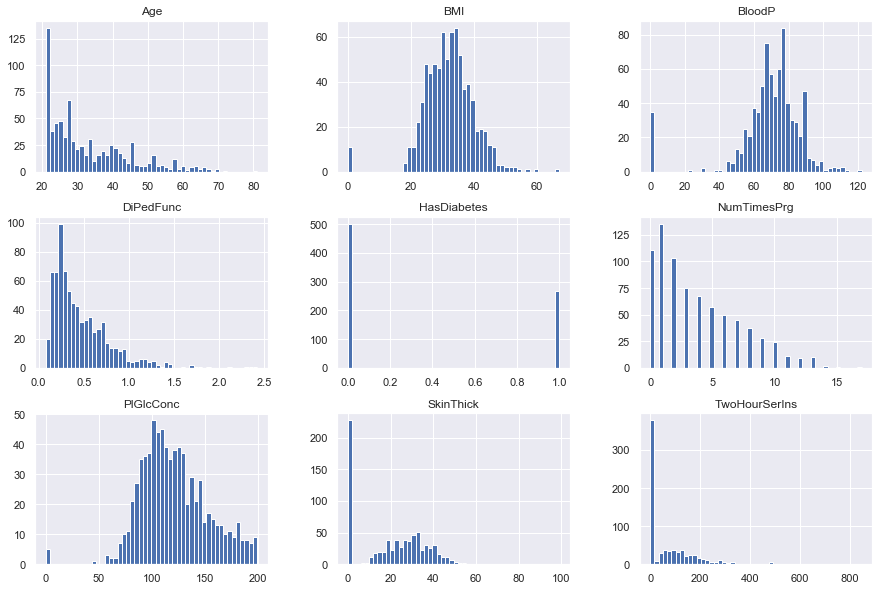

In [10]:
# Visualize the data
data.hist(bins=50, figsize=(15, 10))
plt.show()

In [11]:
# Check for missing values _ no missing values
print(data.isnull().sum()) 

NumTimesPrg      0
PlGlcConc        0
BloodP           0
SkinThick        0
TwoHourSerIns    0
BMI              0
DiPedFunc        0
Age              0
HasDiabetes      0
dtype: int64


In [12]:
### Data cleaning and transformation

# some columns have zero values, which we substitute by the median
# for stability to outliers

median_bmi = data['BMI'].median()
data['BMI'] = data['BMI'].replace(to_replace=0, value=median_bmi)

median_bloodp = data['BloodP'].median()
data['BloodP'] = data['BloodP'].replace(to_replace=0, value=median_bloodp)

median_plglcconc = data['PlGlcConc'].median()
data['PlGlcConc'] = data['PlGlcConc'].replace(to_replace=0, value=median_plglcconc)

median_skinthick = data['SkinThick'].median()
data['SkinThick'] = data['SkinThick'].replace(to_replace=0, value=median_skinthick)

median_twohourserins = data['TwoHourSerIns'].median()
data['TwoHourSerIns'] = data['TwoHourSerIns'].replace(to_replace=0, value=median_twohourserins)

In [13]:
X_data = data.values.copy()
# seperate features from target
X = data.drop("HasDiabetes", axis=1).values
y = data["HasDiabetes"].values

## Tuning k for k-NN

best k is 23 with CV accuracy 0.765


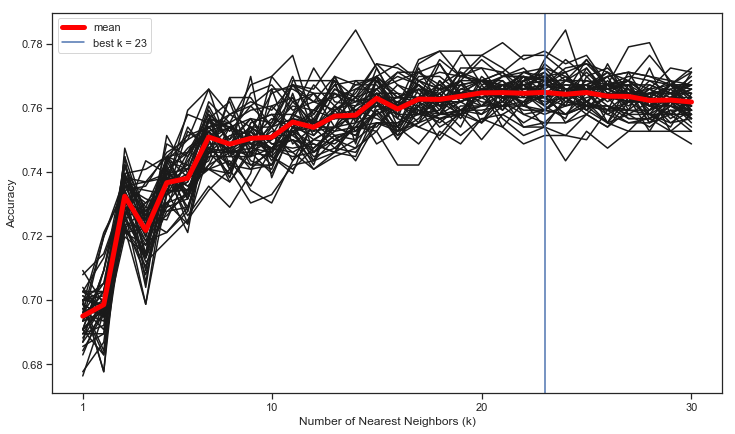

In [14]:
# Find the best value for the parameter k of nearest neighbors via 10-fold CV.

# Since we have few data, the outcome is affected by the random permutation 
# of the indices. For statistical robustness, we perform 10-fold CV for 50 
# random permutations and look at the mean error curve to determine k.

n_folds = 10

num_permutations = 50
max_k = 30
k_values = range(1, max_k+1)
CV_scores = np.zeros((num_permutations, max_k))

sns.set(rc={'figure.figsize':(12, 7)})
sns.set_style("white")
sns.set_style("ticks")
for i in range(num_permutations):
    shuffled_idx = shuffle_index(X.shape[0]) #same shuffle for all k in [1,30]
    for k in k_values:
        cv_error = kfold_cv_knn(X, y, shuffled_idx, n_folds, k, scale_data=True)
        CV_scores[i, k-1] = 1 - cv_error
        
    plt.plot(k_values, CV_scores[i,:], color='k')
    
mean_scores = np.mean(CV_scores, axis=0)
best_k = np.argmax(mean_scores)+1
best_acc = np.max(mean_scores)
print('best k is {} with CV accuracy {:.3f}'.format(best_k, best_acc))


sns.set_style("white")
sns.set_style("ticks")
plt.plot(k_values, mean_scores, color='red', label='mean', linewidth=5)
plt.axvline(x=np.argmax(mean_scores)+1, label='best k = {}'.format(best_k))
plt.xticks([1,10,20,30])
plt.xlabel('Number of Nearest Neighbors (k)')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

## Comparing k-NN, Bayes and Naive Bayes

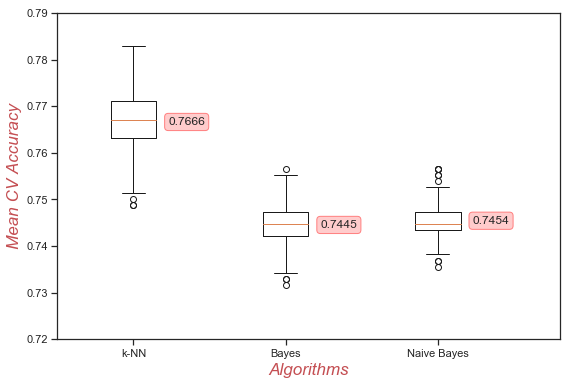

In [15]:
# Compare the the three classifiers:
# Again, we perform 500 experiments, for 500 different random permutations of the indices.
# For each experiment we compute the accuracy of the model via 10-fold CV.
# Finally we plot the mean accuracy across the 500 experiments.

n_folds=10
CV_errors_knn = []
CV_errors_bayes = []
CV_errors_naive = []
num_experiments = 500
for i in range(num_experiments):
    
    shuffled_idx = shuffle_index(X.shape[0])
    
    # KNN classifier 
    KNN_error = kfold_cv_knn(X, y, shuffled_idx, n_folds, 21, scale_data=True)
    CV_errors_knn.append(1-KNN_error)

    # Bayes classifier
    Bayes_error, s0s, m0s, tss = kfold_cv_bayes(X_data, shuffled_idx, n_folds)
    CV_errors_bayes.append(1-Bayes_error)

    # Naive Bayes classifier
    Naive_error = kfold_cv_naive_bayes(X_data, shuffled_idx, n_folds)
    CV_errors_naive.append(1-Naive_error)


# Plot the results
lab_knn = round(np.mean(CV_errors_knn),4)
lab_bayes = round(np.mean(CV_errors_bayes),4)
lab_naive = round(np.mean(CV_errors_naive),4)
data_box = [CV_errors_knn, CV_errors_bayes, CV_errors_naive]
names_al = ["k-NN", "Bayes", "Naive Bayes"]

sns.set(rc={'figure.figsize':(9, 6)})
sns.set_style("white")
sns.set_style("ticks")
fig = plt.figure()
ax = fig.add_subplot(111)
plt.boxplot(data_box)
ax.set_xticklabels(names_al)
plt.xlabel("Algorithms", fontstyle = 'oblique', size = 17, color = "r")
plt.ylabel("Mean CV Accuracy", fontstyle = 'oblique', size = 17, color = "r")
plt.ylim(0.72,0.79)
plt.xlim(0.5,3.8)
bbox_1 = dict(boxstyle="round", ec=(1., 0.5, 0.5), fc=(1., 0.8, 0.8))
plt.text(1.35, lab_knn, lab_knn, size=12, ha="center", va="center", bbox=bbox_1)
plt.text(2.35, lab_bayes, lab_bayes, size=12, ha="center", va="center", bbox=bbox_1)
plt.text(3.35, lab_naive, lab_naive, size=12, ha="center", va="center", bbox=bbox_1)
plt.show()